# STROKE PREDICTION

About the Dataset;

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency, shapiro, mannwhitneyu, t
from IPython.display import display
from statsmodels.stats.proportion import proportion_confint
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from skopt.space import Integer, Categorical
import joblib
from pathlib import Path

## Load the dataset


In [2]:
file_path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(file_path)

df_info = df.info()
df_head = df.head()

df_shape = df.shape
df_columns = df.columns.tolist()

df_info, df_shape, df_columns, df_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


(None,
 (5110, 12),
 ['id',
  'gender',
  'age',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'avg_glucose_level',
  'bmi',
  'smoking_status',
  'stroke'],
       id  gender   age  hypertension  heart_disease ever_married  \
 0   9046    Male  67.0             0              1          Yes   
 1  51676  Female  61.0             0              0          Yes   
 2  31112    Male  80.0             0              1          Yes   
 3  60182  Female  49.0             0              0          Yes   
 4   1665  Female  79.0             1              0          Yes   
 
        work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
 0        Private          Urban             228.69  36.6  formerly smoked   
 1  Self-employed          Rural             202.21   NaN     never smoked   
 2        Private          Rural             105.92  32.5     never smoked   
 3        Private          Urban             171.23  34.4           

##### Here are the basics:

- Shape: 5110 rows × 12 columns

- Missing values: Only the bmi column has missing entries.

Data types:

- Numerical: `age`, `avg_glucose_level`, `bmi`

- Categorical: `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`

- Binary: `hypertension`, `heart_disease`,`stroke`
---

### Data Summary

In [3]:
missing_values = df.isnull().sum()

duplicate_count = df.duplicated().sum()

summary_stats = df.describe()

missing_values, duplicate_count, summary_stats

(id                     0
 gender                 0
 age                    0
 hypertension           0
 heart_disease          0
 ever_married           0
 work_type              0
 Residence_type         0
 avg_glucose_level      0
 bmi                  201
 smoking_status         0
 stroke                 0
 dtype: int64,
 0,
                  id          age  hypertension  heart_disease  \
 count   5110.000000  5110.000000   5110.000000    5110.000000   
 mean   36517.829354    43.226614      0.097456       0.054012   
 std    21161.721625    22.612647      0.296607       0.226063   
 min       67.000000     0.080000      0.000000       0.000000   
 25%    17741.250000    25.000000      0.000000       0.000000   
 50%    36932.000000    45.000000      0.000000       0.000000   
 75%    54682.000000    61.000000      0.000000       0.000000   
 max    72940.000000    82.000000      1.000000       1.000000   
 
        avg_glucose_level          bmi       stroke  
 count        5110.

##### Summary Statistics (Highlights):

- Age: Range from 0.08 to 82 years

- Average Glucose Level: Mean = 106.15, Max = 271.74

- BMI: Mean = 28.89, but some very high outliers (max = 97.6)

- Stroke Incidence: ~4.87% of patients had a stroke → class imbalance
---

## EDA

### Distribution of Features

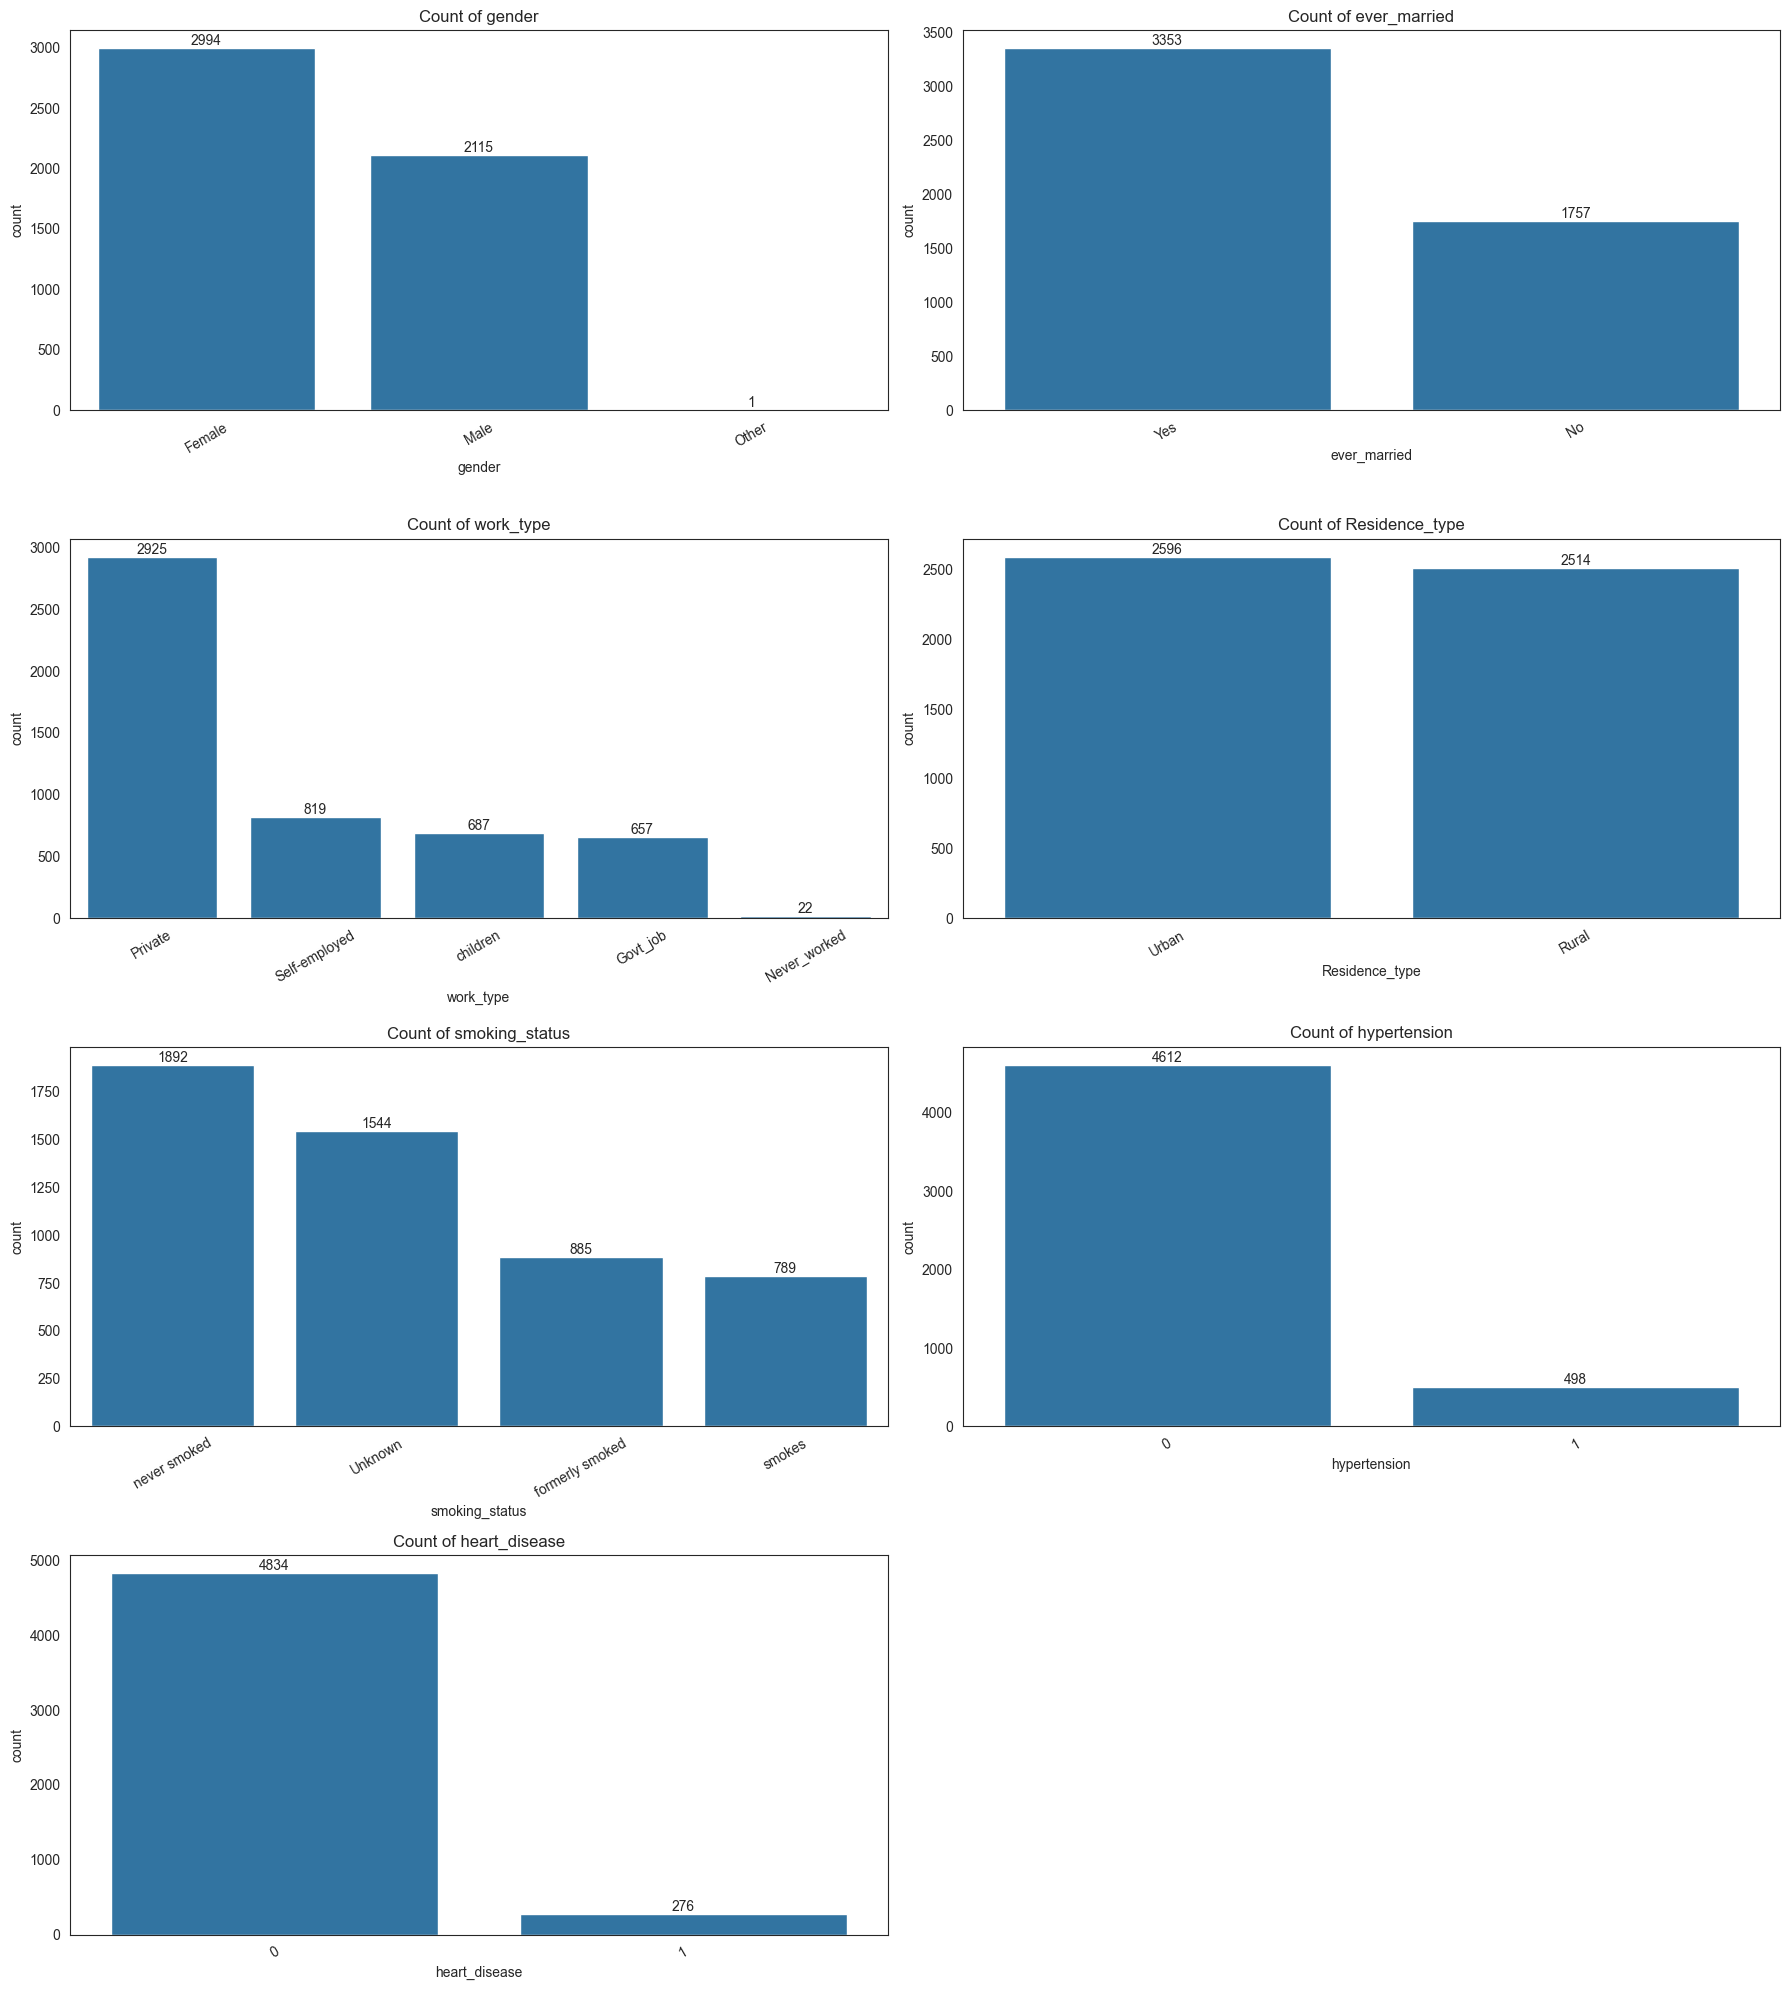

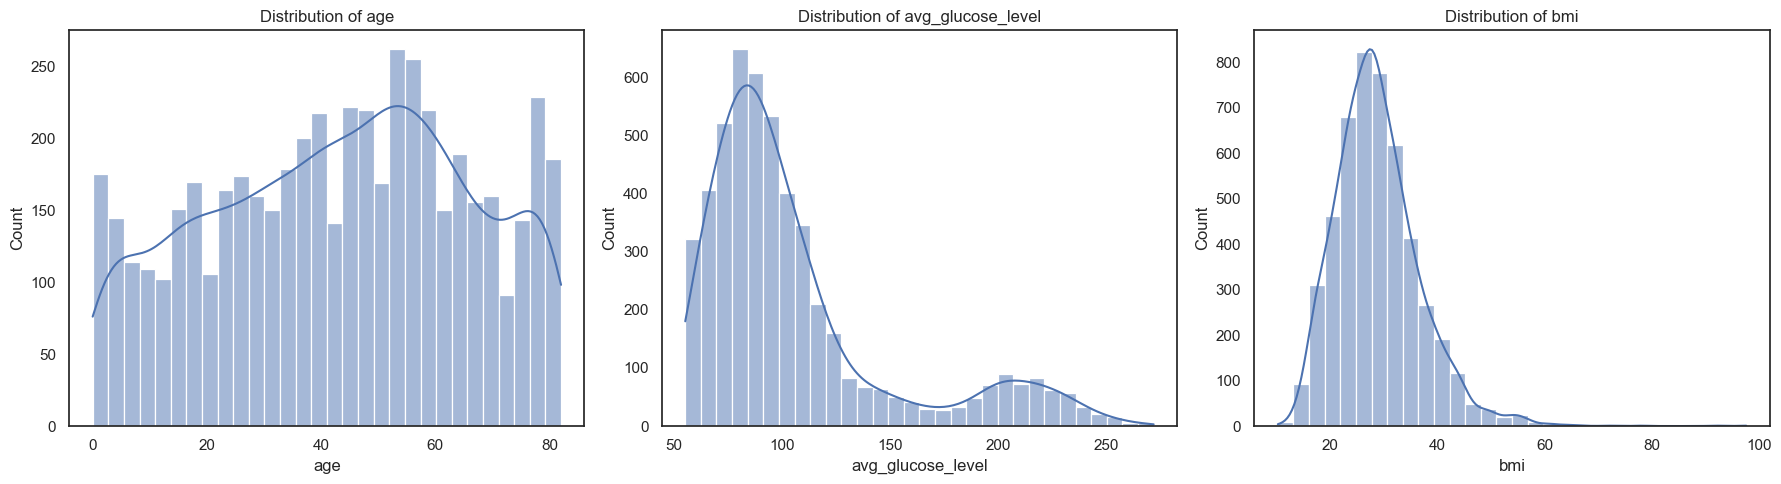

In [4]:
sns.set_style("white")

categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]

fig, axes = plt.subplots(4, 2, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    plot = sns.countplot(data=df, x=col, ax=axes[i], order=df[col].value_counts().index)
    axes[i].set_title(f"Count of {col}")
    axes[i].tick_params(axis="x", rotation=30)
    axes[i].grid(False)

    for container in axes[i].containers:
        axes[i].bar_label(container, fmt="%d")

axes[-1].axis("off")

plt.tight_layout()
plt.show()
sns.set(style="white")

numerical_cols = ["age", "avg_glucose_level", "bmi"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

1. Numerical Features:

    - Age: Bimodal distribution with peaks around childhood and old age.

    - Glucose Level: Right-skewed, with a significant number of patients having elevated glucose levels.
    
    - BMI: Mostly normal distribution but with outliers > 60.

2. Categorical Features:

    - Gender: Fairly balanced between Male and Female.

    - Ever Married: Most patients have been married.
    
    - Work Type: Most are in Private or Self-employed jobs; few are "Never worked" or "Children".
    
    - Residence Type: Roughly evenly split between Urban and Rural.
    
    - Smoking Status: Large number of "Unknown" entries.

3. Binary Features:

    - Hypertension: Highly imbalanced with most patients not having hypertension.

    - Heart_disease: Just like hypertension, highly imbalanced with many more patients not having heart disease compared to thoser that to. 

---

#### Stroke vs Numerical Features

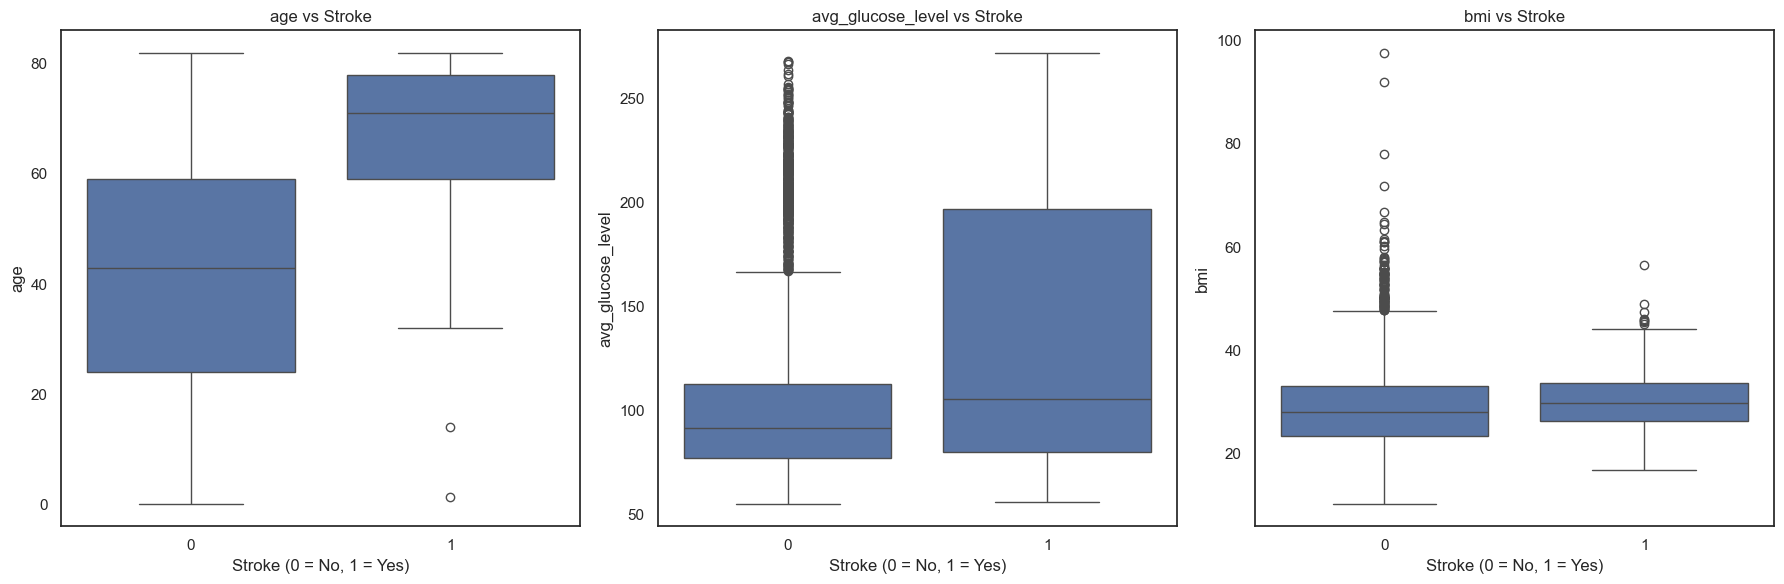

In [5]:
sns.set_style("white")

numerical_cols = ["age", "avg_glucose_level", "bmi"]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x="stroke", y=col, ax=axes[i])
    axes[i].set_title(f"{col} vs Stroke")
    axes[i].set_xlabel("Stroke (0 = No, 1 = Yes)")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

##### Boxplot Analysis — Stroke vs Numeric Features

Each boxplot shows how a numeric feature is distributed with respect to stroke outcome (0 = No Stroke, 1 = Stroke):

1. Age vs Stroke:
    - Stroke patients tend to be significantly older.

    - The median age for stroke patients is much higher, suggesting age is a strong risk factor.

2. Avg Glucose Level vs Stroke:
    - Stroke patients often show higher average glucose levels.

    - Several extreme outliers are visible, especially for stroke cases — indicating possible diabetes or metabolic syndrome links.

3. BMI vs Stroke:
    - Distribution is fairly similar between groups, though slightly higher median for stroke patients.
    
    - Some very high BMI outliers exist — possibly worth flagging during preprocessing.

---

### Correlations

In [6]:
# 1. Point Biserial Correlation for numerical + binary features
numerical_binary_cols = [
    "age",
    "avg_glucose_level",
    "bmi",
    "hypertension",
    "heart_disease",
]
pb_corr = {}
for col in numerical_binary_cols:
    clean_df = df[[col, "stroke"]].dropna()
    r, p_value = pointbiserialr(clean_df["stroke"], clean_df[col])
    pb_corr[col] = round(r, 3)


# 2. Cramér’s V for categorical features
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return round(np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1))), 3)


categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]
cramers_v_scores = {}

for col in categorical_cols:
    confusion_mat = pd.crosstab(df[col], df["stroke"])
    cramers_v_scores[col] = cramers_v(confusion_mat)

combined_scores = {**pb_corr, **cramers_v_scores}
combined_df = pd.DataFrame.from_dict(
    combined_scores, orient="index", columns=["Association with Stroke"]
)
combined_df.sort_values(by="Association with Stroke", ascending=False, inplace=True)

display(combined_df)

plt.show()

,Association with Stroke
age,0.245
heart_disease,0.135
avg_glucose_level,0.132
hypertension,0.128
ever_married,0.106
work_type,0.094
smoking_status,0.072
bmi,0.042
Residence_type,0.004
gender,0.000


**Note**

- Point Biserial correlation was used for continuous features, and Cramér’s V for categorical features, to correctly measure association strength with the binary stroke outcome.
- All features show moderate to poor corelatioin with stroke when consdering accepatable numbers for strong correlation.


    1. Age, glucose level, hypertension, and heart disease are the strongest predictors.

    2. Work type, smoking, gender, and residence have weak or negligible direct associations with stroke.

    3. Marital status slightly correlates, likely indirectly through age.

---

## Statistical Inference


**Population**: All patients included in the Stroke Prediction dataset.

#### Hypothesis

**Hypothesis 1 (Age and Stroke)**
- H₀: There is no difference in mean age between stroke and non-stroke patients.

- H₁: There is a significant difference in mean age between stroke and non-stroke patients.

**Hypothesis 2 (Average Glucose and Stroke)**
- H₀: There is no difference in mean average glucose levels between stroke and non-stroke patients.

- H₁: There is a significant difference in mean average glucose levels between stroke and non-stroke patients.

**Hypothesis 3 (Hypertension and Stroke)**
- H₀: The proportion of hypertension is the same in stroke and non-stroke patients.

- H₁: The proportion of hypertension differs between stroke and non-stroke patients.

**Significance Level (α)**: Set at 0.05.

---

### Normality tests


#### Normality Testing for Numerical Features

Before applying statistical inference, it is critical to test the normality assumption for numerical features.  
The Shapiro-Wilk test was used for the following variables, separately for stroke and non-stroke groups:
- Age
- Average Glucose Level
- Body Mass Index (BMI)

##### Hypotheses for Normality Tests:
- **Null Hypothesis (H₀)**: The data is normally distributed.
- **Alternative Hypothesis (H₁)**: The data is not normally distributed.

A significance level (α) of **0.05** was used for decision making.

The distributions are visualized below:
- Red curves = Stroke patients
- Blue curves = Non-stroke patients


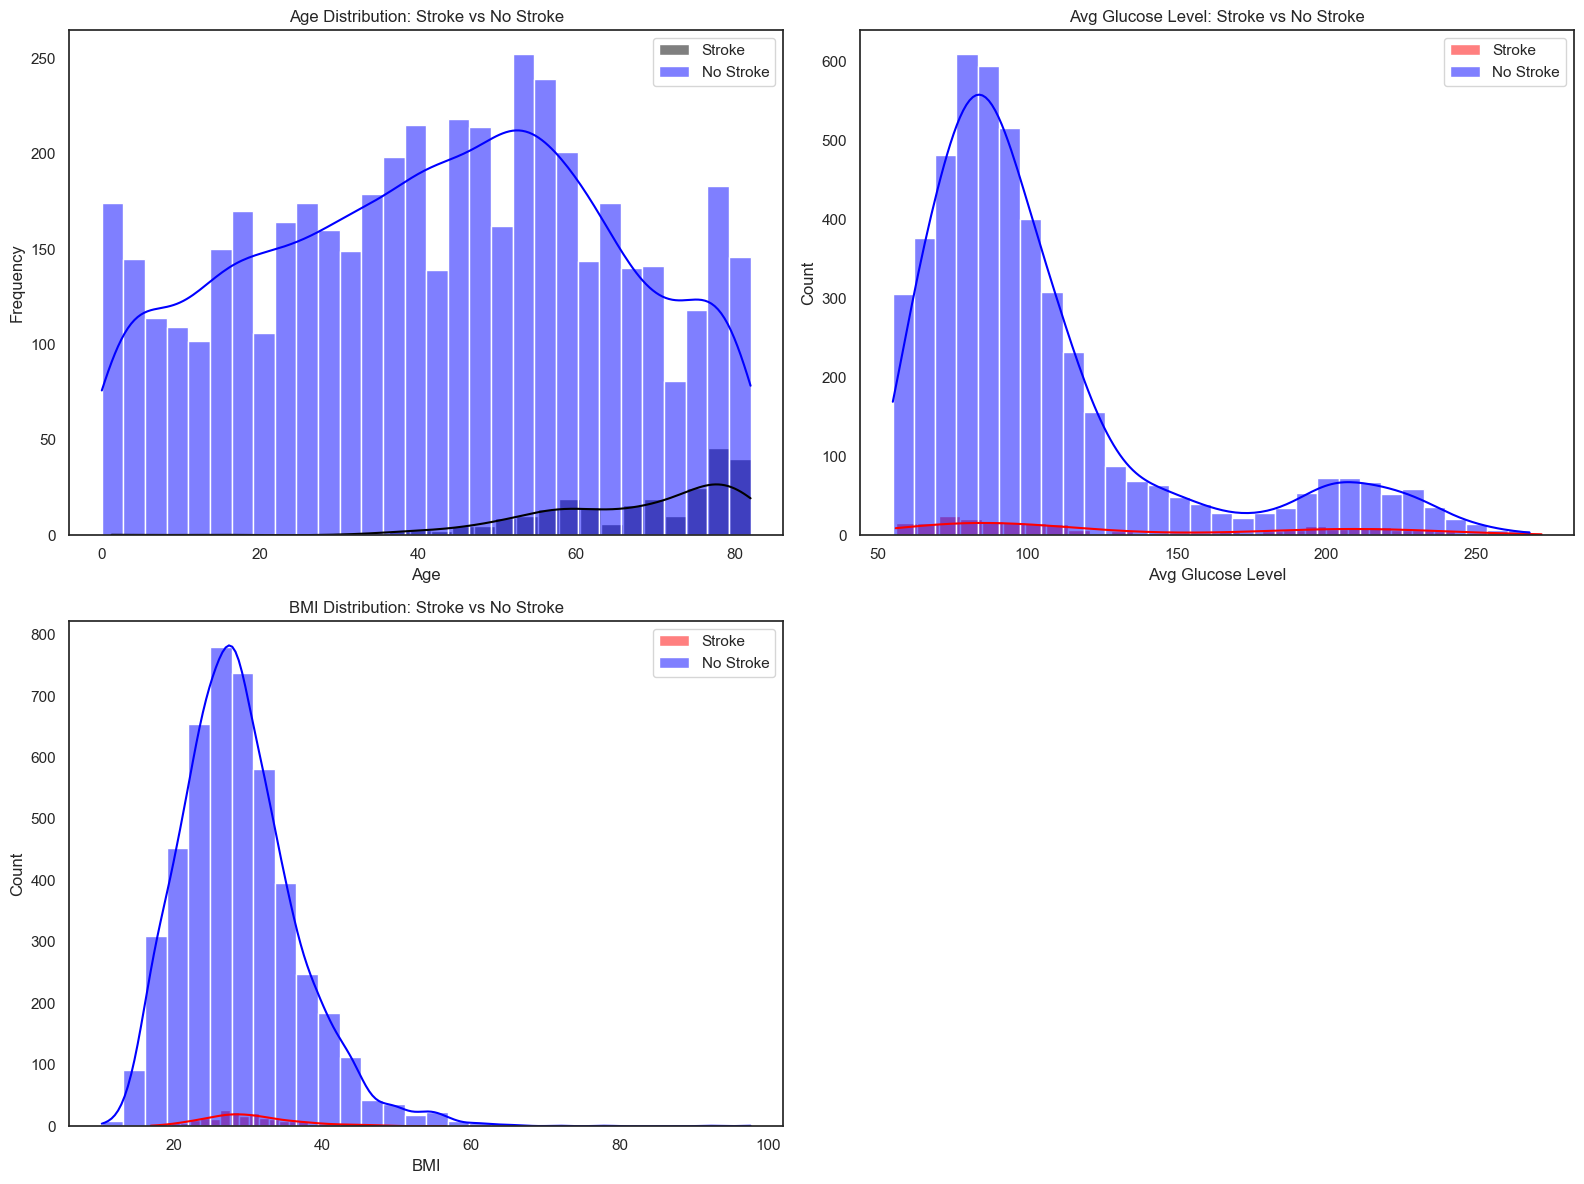

Shapiro-Wilk Test Results:
Age (Stroke): p-value = 3.1737e-13
Age (No Stroke): p-value = 1.6333e-30
Avg Glucose Level (Stroke): p-value = 1.2320e-13
Avg Glucose Level (No Stroke): p-value = 1.1475e-60
BMI (Stroke): p-value = 5.2359e-06
BMI (No Stroke): p-value = 1.3678e-36


In [7]:
age_stroke = df[df["stroke"] == 1]["age"].dropna()
age_no_stroke = df[df["stroke"] == 0]["age"].dropna()

glucose_stroke = df[df["stroke"] == 1]["avg_glucose_level"].dropna()
glucose_no_stroke = df[df["stroke"] == 0]["avg_glucose_level"].dropna()

bmi_stroke = df[df["stroke"] == 1]["bmi"].dropna()
bmi_no_stroke = df[df["stroke"] == 0]["bmi"].dropna()

# Shapiro-Wilk normality tests
shapiro_age_stroke = shapiro(age_stroke)
shapiro_age_no_stroke = shapiro(age_no_stroke)
shapiro_glucose_stroke = shapiro(glucose_stroke)
shapiro_glucose_no_stroke = shapiro(glucose_no_stroke)
shapiro_bmi_stroke = shapiro(bmi_stroke)
shapiro_bmi_no_stroke = shapiro(bmi_no_stroke)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- AGE ---
sns.histplot(
    age_stroke, kde=True, color="black", label="Stroke", bins=30, ax=axes[0, 0]
)
sns.histplot(
    age_no_stroke, kde=True, color="blue", label="No Stroke", bins=30, ax=axes[0, 0]
)
axes[0, 0].set_title("Age Distribution: Stroke vs No Stroke")
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].legend()
axes[0, 0].grid(False)

# --- AVG GLUCOSE LEVEL ---
sns.histplot(
    glucose_stroke, kde=True, color="red", label="Stroke", bins=30, ax=axes[0, 1]
)
sns.histplot(
    glucose_no_stroke, kde=True, color="blue", label="No Stroke", bins=30, ax=axes[0, 1]
)
axes[0, 1].set_title("Avg Glucose Level: Stroke vs No Stroke")
axes[0, 1].set_xlabel("Avg Glucose Level")
axes[0, 1].legend()
axes[0, 1].grid(False)

# --- BMI ---
sns.histplot(bmi_stroke, kde=True, color="red", label="Stroke", bins=30, ax=axes[1, 0])
sns.histplot(
    bmi_no_stroke, kde=True, color="blue", label="No Stroke", bins=30, ax=axes[1, 0]
)
axes[1, 0].set_title("BMI Distribution: Stroke vs No Stroke")
axes[1, 0].set_xlabel("BMI")
axes[1, 0].legend()
axes[1, 0].grid(False)

axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

print("Shapiro-Wilk Test Results:")
print(f"Age (Stroke): p-value = {shapiro_age_stroke.pvalue:.4e}")
print(f"Age (No Stroke): p-value = {shapiro_age_no_stroke.pvalue:.4e}")
print(f"Avg Glucose Level (Stroke): p-value = {shapiro_glucose_stroke.pvalue:.4e}")
print(
    f"Avg Glucose Level (No Stroke): p-value = {shapiro_glucose_no_stroke.pvalue:.4e}"
)
print(f"BMI (Stroke): p-value = {shapiro_bmi_stroke.pvalue:.4e}")
print(f"BMI (No Stroke): p-value = {shapiro_bmi_no_stroke.pvalue:.4e}")

#### Results:

| Feature | Group | Shapiro-Wilk p-value | Interpretation |
|:--------|:------|:---------------------|:---------------|
| Age | Stroke | *p* < 0.05 | Not normal |
| Age | No Stroke | *p* < 0.05 | Not normal |
| Avg Glucose Level | Stroke | *p* < 0.05 | Not normal |
| Avg Glucose Level | No Stroke | *p* < 0.05 | Not normal |
| BMI | Stroke | *p* < 0.05 | Not normal |
| BMI | No Stroke | *p* < 0.05 | Not normal |

#### Conclusion:

Since all tested variables failed the normality assumption (p-value < 0.05), we will use **non-parametric tests** (Mann-Whitney U Test) instead of parametric t-tests in subsequent hypothesis testing.

---

### Statistical Tests for hypothesis

#### Age and Stroke

In [8]:
age_stroke = df[df["stroke"] == 1]["age"].dropna()
age_no_stroke = df[df["stroke"] == 0]["age"].dropna()

u_statistic, p_value = mannwhitneyu(age_stroke, age_no_stroke, alternative="two-sided")

u_statistic, p_value

(1010125.5, 3.726634665900012e-71)

##### Hypothesis 1: Age and Stroke Relationship

**Hypotheses:**
- H₀: There is no difference in the age distribution between stroke and non-stroke patients.
- H₁: There is a significant difference in the age distribution between stroke and non-stroke patients.

**Test Used:**  
Since age was not normally distributed (based on the Shapiro-Wilk test), we applied the **Mann-Whitney U Test** — a non-parametric alternative to the independent t-test.

**Results:**
- U-statistic = 1,010,125.5
- p-value ≈ 3.73e-71

**Conclusion:**  

- Because the p-value is far smaller than 0.05, we reject the null hypothesis. 

- There is a statistically significant difference in the age distributions between stroke and non-stroke patients.
  
- Stroke patients tend to be older than non-stroke patients.

---


#### Average Glucose Level and Stroke

In [9]:
glucose_stroke = df[df["stroke"] == 1]["avg_glucose_level"].dropna()
glucose_no_stroke = df[df["stroke"] == 0]["avg_glucose_level"].dropna()

u_statistic_glucose, p_value_glucose = mannwhitneyu(
    glucose_stroke, glucose_no_stroke, alternative="two-sided"
)

u_statistic_glucose, p_value_glucose

(739150.0, 3.6403672710893244e-09)

##### Hypothesis 2: Average Glucose Level and Stroke Relationship

**Hypotheses:**
- H₀: There is no difference in the average glucose level between stroke and non-stroke patients.
- H₁: There is a significant difference in the average glucose level between stroke and non-stroke patients.

**Test Used:**  
Since average glucose level was not normally distributed (based on the Shapiro-Wilk test), we applied the **Mann-Whitney U Test** — a non-parametric alternative to the independent t-test.

**Results:**
- U-statistic = 739,150.0
- p-value ≈ 3.64 × 10⁻⁹

**Conclusion:**  
Because the p-value is much smaller than 0.05, we reject the null hypothesis.  
There is a statistically significant difference in average glucose levels between stroke and non-stroke patients.  
Stroke patients tend to have higher glucose levels than non-stroke patients.

---


#### Hypertension and Stroke

In [10]:
contingency_table = pd.crosstab(df["hypertension"], df["stroke"])

chi2_stat, p_value_hyper, dof, expected = chi2_contingency(contingency_table)

chi2_stat, p_value_hyper, dof

(81.6053682482931, 1.661621901511823e-19, 1)

##### Hypothesis 3: Hypertension and Stroke Relationship

**Hypotheses:**
- H₀: Hypertension status is independent of stroke occurrence (no association).
- H₁: Hypertension status is associated with stroke occurrence.

**Test Used:**  
Since both hypertension and stroke are categorical variables, we applied the **Chi-Square Test of Independence**.

**Results:**
- Chi-Square Statistic (χ²) = 81.61
- Degrees of Freedom = 1
- p-value ≈ 1.66 × 10⁻¹⁹

**Conclusion:**  
Because the p-value is far smaller than 0.05, we reject the null hypothesis.  
There is a statistically significant association between hypertension and stroke occurrence.  
Patients with hypertension are more likely to experience a stroke compared to those without hypertension.

---


### Confidence Intervals

#### Confidence Interval for Mean Age of Stroke Patients

Mean Age of Stroke Patients: 67.73 years
95% Confidence Interval: (66.14, 69.32) years


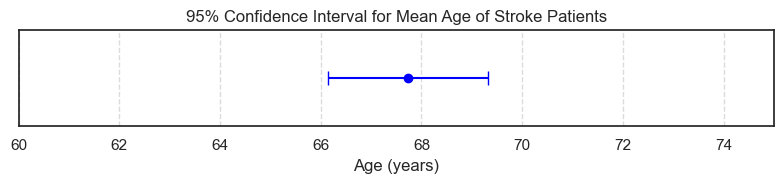

In [11]:
age_stroke = df[df["stroke"] == 1]["age"].dropna()

mean_age = np.mean(age_stroke)
std_age = np.std(age_stroke, ddof=1)  # sample standard deviation
n_age = len(age_stroke)

confidence = 0.95
alpha = 1 - confidence

t_critical = t.ppf(1 - alpha / 2, df=n_age - 1)

margin_of_error = t_critical * (std_age / np.sqrt(n_age))

ci_lower_age = mean_age - margin_of_error
ci_upper_age = mean_age + margin_of_error

print(f"Mean Age of Stroke Patients: {mean_age:.2f} years")
print(f"95% Confidence Interval: ({ci_lower_age:.2f}, {ci_upper_age:.2f}) years")

plt.figure(figsize=(8, 2))
plt.errorbar(
    x=mean_age,
    y=0,
    xerr=[[mean_age - ci_lower_age], [ci_upper_age - mean_age]],
    fmt="o",
    color="blue",
    capsize=5,
)

plt.title("95% Confidence Interval for Mean Age of Stroke Patients")
plt.yticks([])
plt.xlabel("Age (years)")
plt.xlim(60, 75)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

##### Confidence Interval: Mean Age of Stroke Patients

**Goal:**  
Estimate the true mean age of stroke patients in the population.

**Method Used:**  
Since age is a continuous variable and sample size is moderate, we used a **t-distribution** to construct a 95% confidence interval.

**Results:**
- Sample Mean Age = 67.73 years
- 95% Confidence Interval = (66.14, 69.32) years

**Conclusion:**  
We are 95% confident that the true mean age of stroke patients lies between approximately 66.14 and 69.32 years.  
This suggests that strokes predominantly occur in older individuals in this dataset.

---


#### Confidence Interval for Proportion of Stroke Patients with Hypertension

Proportion of Stroke Patients with Hypertension: 0.265 (26.51%)
95% Confidence Interval: (0.210, 0.320)


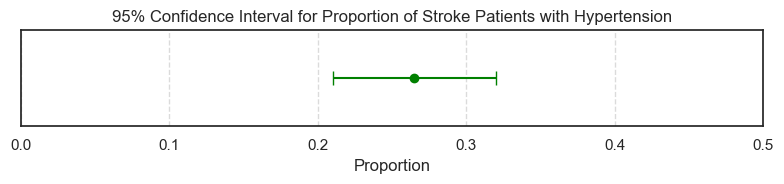

In [12]:
stroke_patients = df[df["stroke"] == 1]

stroke_with_hypertension = stroke_patients["hypertension"].sum()

total_stroke_patients = len(stroke_patients)

prop_hypertension = stroke_with_hypertension / total_stroke_patients

confidence = 0.95
alpha = 1 - confidence

ci_lower_prop, ci_upper_prop = proportion_confint(
    stroke_with_hypertension, total_stroke_patients, alpha=alpha, method="normal"
)

print(
    f"Proportion of Stroke Patients with Hypertension: {prop_hypertension:.3f} ({prop_hypertension*100:.2f}%)"
)
print(f"95% Confidence Interval: ({ci_lower_prop:.3f}, {ci_upper_prop:.3f})")

# Visualization
plt.figure(figsize=(8, 2))
plt.errorbar(
    x=prop_hypertension,
    y=0,
    xerr=[[prop_hypertension - ci_lower_prop], [ci_upper_prop - prop_hypertension]],
    fmt="o",
    color="green",
    capsize=5,
)

plt.title("95% Confidence Interval for Proportion of Stroke Patients with Hypertension")
plt.yticks([])
plt.xlabel("Proportion")
plt.xlim(0, 0.5)
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

##### Confidence Interval: Proportion of Stroke Patients with Hypertension

**Goal:**  
Estimate the true proportion of stroke patients who also have hypertension.

**Method Used:**  
Since hypertension is a binary variable, we used a **normal approximation** to construct a 95% confidence interval for the proportion.

**Results:**
- Sample Proportion = 26.5%
- 95% Confidence Interval = (21.0%, 32.0%)

**Conclusion:**  
We are 95% confident that between 21% and 32% of stroke patients in the population have hypertension.  
This highlights the significant overlap between hypertension and stroke occurrence.

---


### Transition to Machine Learning Modeling

#### Summary of Insights:
- Age, average glucose level, hypertension, and heart disease showed the strongest associations with stroke occurrence.
- Statistically significant differences were observed in age, glucose level, and hypertension between stroke and non-stroke groups.
- Confidence intervals confirmed that stroke patients are generally older and that a substantial proportion have hypertension.

#### Next Steps:
Having completed exploratory data analysis and statistical inference, we will now develop machine learning models to predict the likelihood of a patient experiencing a stroke.

The modeling process will include:
- Data Preprocessing
- Feature Engineering
- Model Selection and Evaluation
- Hyperparameter Tuning
- Final Model Deployment

---


## Machine Learning Modeling 


#### 1. Data Preprocessing
- Handle missing values
- Encode categorical variables
- Feature scaling (if needed)

#### 2. Train/Test Split
- 70/30 split
- Stratify by `stroke` to maintain class balance

#### 3. Baseline Models
- Logistic Regression
- Decision Tree
- Random Forest
- (optional) XGBoost / LightGBM for boosting

#### 4. Model Evaluation
- Accuracy
- Precision, Recall, F1-Score
- ROC Curve and AUC

#### 5. Hyperparameter Tuning
- Grid Search or Random Search
- Possibly Bayesian Optimization (if you want extra polish!)

#### 6. Model Comparison
- Compare validation scores
- Compare time durations

#### 7. Final Model Selection
- Choose the best performing model
- Retrain on full training data
- Evaluate on holdout test set

#### 8. Model Deployment (Optional)
- Save model (Pickle or Joblib)
- Set up API or web app (optional bonus)

---


### Data preprocessing

#### Handling missing values

In [13]:
start_time = time.time()

print("Missing values before handling:")
display(df.isnull().sum())

median_bmi = df["bmi"].median()
df["bmi"] = df["bmi"].fillna(median_bmi)

print("\nMissing values after handling:")
display(df.isnull().sum())

end_time = time.time()

print(f"\nDuration for missing value handling: {end_time - start_time:.2f} seconds")

Missing values before handling:


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Missing values after handling:


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Duration for missing value handling: 0.01 seconds


##### Data Preprocessing: Handling Missing Values

**Task:**  
Handle missing values before feeding the data into machine learning models.

**Method:**  
- Only the `bmi` feature had missing values (201 missing entries).
- Median imputation was chosen to fill missing BMI values, as it is robust to outliers compared to mean imputation.

**Outcome:**
- All missing values were successfully handled.
- Median value of `bmi` was used to fill missing entries.

**Timing:**
- Total duration for missing value handling: approximately 0.01 seconds.

---


#### Encoding Categorical Features

In [14]:
start_time = time.time()

"""Encode binary categorical features"""

binary_cols = ["gender", "ever_married", "Residence_type"]
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

"""One-hot encode multiclass features"""

multiclass_cols = ["work_type", "smoking_status"]
df = pd.get_dummies(df, columns=multiclass_cols, drop_first=True)

"""Convert all boolean columns to integers (0/1)"""

df = df.astype({col: "int" for col in df.select_dtypes(include="bool").columns})

end_time = time.time()

print(f"New dataset shape: {df.shape}")
print(f"Duration for categorical encoding: {end_time - start_time:.2f} seconds")

df.head(8)

New dataset shape: (5110, 17)
Duration for categorical encoding: 0.01 seconds


,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,228.69,36.6,1,0,1,0,0,1,0,0
1,51676,0,61.0,0,0,1,0,202.21,28.1,1,0,0,1,0,0,1,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,1,0,1,0,0,0,1,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,1,0,1,0,0,0,0,1
4,1665,0,79.0,1,0,1,0,174.12,24.0,1,0,0,1,0,0,1,0
5,56669,1,81.0,0,0,1,1,186.21,29.0,1,0,1,0,0,1,0,0
6,53882,1,74.0,1,1,1,0,70.09,27.4,1,0,1,0,0,0,1,0
7,10434,0,69.0,0,0,0,1,94.39,22.8,1,0,1,0,0,0,1,0


#### Data Preprocessing: Encoding Categorical Variables

**Task:**  
Convert categorical variables into numerical format suitable for machine learning models.

**Method:**
- Binary features (`gender`, `ever_married`, `Residence_type`) were encoded using **Label Encoding**.

- Multiclass features (`work_type`, `smoking_status`) were encoded using **One-Hot Encoding**.

- `drop_first=True` was applied during one-hot encoding to avoid multicollinearity (dummy variable trap).

**Outcome:**
- All features are now numeric.
- The dataset is ready for train/test split and modeling.

**Timing:**
- Total duration for categorical encoding: approximately 0.01 seconds.

---


### Data Splitting 


In [15]:
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

X = df.drop(["id", "stroke"], axis=1)
y = df["stroke"]

# 70/30 stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

end_time = time.time()

print("Train/Test split (70/30) completed.")
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Duration: {end_time - start_time:.2f} seconds")

Train/Test split (70/30) completed.
Training set: (3577, 15), Test set: (1533, 15)
Duration: 0.08 seconds


##### Train/Test Split (70/30)

**Task:**  
Split the data into training and testing sets for model training and evaluation.

**Method:**
- Feature matrix `X` excludes `id` and `stroke`.

- Target vector `y` is the `stroke` column.

- A **70/30 stratified split** was used to maintain class balance.

- `random_state=42` ensures reproducibility.

**Outcome:**
- Training Set: 3,577 rows
- Test Set: 1,533 rows
- Number of features: 15

**Timing:**
- Train/Test split completed in approximately 0.01 seconds.

---


### Baseline Models

In [16]:
def evaluate_model(
    model=None, X_test=None, y_test=None, model_name="Model", y_pred=None, y_proba=None
):
    if y_pred is None and model is not None:
        y_pred = model.predict(X_test)
    if y_proba is None and model is not None and hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\nEvaluation for {model_name}")
    print(f"Accuracy (wgt):  {acc:.4f}")
    print(f"Precision (wgt): {prec:.4f}")
    print(f"Recall (wgt):    {rec:.4f}")
    print(f"F1-Score (wgt):  {f1:.4f}")
    if auc is not None:
        print(f"AUC:             {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(f"                Predicted No    Predicted Yes")
    print(f"Actual No       {cm[0, 0]:<16} {cm[0, 1]}")
    print(f"Actual Yes      {cm[1, 0]:<16} {cm[1, 1]}")

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc,
    }

#### Logistic Regression

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()

"""Train Logistic Regression on scaled data"""
logreg_scaled = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
)
logreg_scaled.fit(X_train_scaled, y_train)

end_time = time.time()
print(
    f"Logistic Regression (scaled) training time: {end_time - start_time:.2f} seconds"
)

logreg_scaled_results = evaluate_model(
    logreg_scaled, X_test_scaled, y_test, model_name="Logistic Regression (Scaled)"
)

Logistic Regression (scaled) training time: 0.01 seconds

Evaluation for Logistic Regression (Scaled)
Accuracy (wgt):  0.7312
Precision (wgt): 0.9433
Recall (wgt):    0.7312
F1-Score (wgt):  0.8075
AUC:             0.8389

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1062             396
Actual Yes      16               59


##### Baseline Model: Logistic Regression

**Model 1: Logistic Regression (Unscaled)**  
- Class weight: balanced  
- Accuracy: 72.99%  
- Precision: 12.91%  
- Recall: 78.67%  
- F1-Score: 22.18%  
- AUC: 0.8387  

**Model 2: Logistic Regression (Scaled Features)**  
- Features were standardized using `StandardScaler`

Weighted metrics: 
- Accuracy: 73.12% 

- Precision: 94.33% 

- Recall: 73.12%

- F1-Score: 80.75% 
 
- AUC: 0.8389  

**Conclusion:**  
Standardizing the input features led to a slight improvement in performance and is generally recommended for models like Logistic Regression.  
Recall remained strong in both cases, making Logistic Regression a solid baseline for detecting stroke cases despite class imbalance.


#### Decision Trees Model

In [18]:
start_time = time.time()

dtree = DecisionTreeClassifier(class_weight="balanced", random_state=42)
dtree.fit(X_train, y_train)

end_time = time.time()
print(f"Decision Tree training time: {end_time - start_time:.2f} seconds")

dtree_results = evaluate_model(dtree, X_test, y_test, model_name="Decision Tree")

Decision Tree training time: 0.01 seconds

Evaluation for Decision Tree
Accuracy (wgt):  0.9250
Precision (wgt): 0.9137
Recall (wgt):    0.9250
F1-Score (wgt):  0.9191
AUC:             0.5305

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1411             47
Actual Yes      68               7


##### Baseline Model: Decision Tree

**Model:** Decision Tree Classifier  
- Class weight: balanced  
- Feature scaling: Not applied (tree-based models do not require it)

**Results:**
- Accuracy: 92.50%
- Precision: 91.37%
- Recall: 92,50%
- F1-Score: 91.91%
- AUC: 0.5305

**Conclusion:**  

Despite high accuracy, the decision tree performed poorly on AUC, indicating it failed to identify most stroke cases.  
This is a classic example of how accuracy alone can be misleading in imbalanced classification problems.


#### Random Forest Model

In [19]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
end_time = time.time()

print(f"Random Forest training time: {end_time - start_time:.2f} seconds")
rf_results = evaluate_model(rf, X_test, y_test, model_name="Random Forest")

Random Forest training time: 0.23 seconds

Evaluation for Random Forest
Accuracy (wgt):  0.9498
Precision (wgt): 0.9045
Recall (wgt):    0.9498
F1-Score (wgt):  0.9266
AUC:             0.8040

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1456             2
Actual Yes      75               0


##### Baseline Model: Random Forest

**Model:** Random Forest Classifier  
- n_estimators: 100  
- Class weight: balanced  
- Feature scaling: Not applied (not needed for tree-based models)

**Results:**
- Accuracy: 95.04%
- Precision: 90.45%
- Recall: 94.98%
- F1-Score: 92.66%
- AUC: 0.8040

**Conclusion:**  

Despite high accuracy and a decent AUC, the Random Forest model failed to predict any positive (stroke) cases. 

This highlights the danger of using accuracy alone when dealing with highly imbalanced datasets.  

Further techniques like threshold tuning, resampling, or ensemble methods will be necessary to address this issue.


#### XGBoost Model

In [20]:
start_time = time.time()
xgb = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
)
xgb.fit(X_train, y_train)
end_time = time.time()

print(f"\nXGBoost training time: {end_time - start_time:.2f} seconds")
xgb_results = evaluate_model(xgb, X_test, y_test, model_name="XGBoost")


XGBoost training time: 0.12 seconds

Evaluation for XGBoost
Accuracy (wgt):  0.9315
Precision (wgt): 0.9246
Recall (wgt):    0.9315
F1-Score (wgt):  0.9279
AUC:             0.7973

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1413             45
Actual Yes      60               15


##### Baseline Model: XGBoost

**Model:**  
An XGBoost Classifier was trained with parameters adjusted to handle class imbalance (using `scale_pos_weight`) and model complexity was constrained (e.g., limited tree depth and early stopping). 

**Results:**  
- **Accuracy:** 93.15%  

- **Weighted Precision:** 92.46%  

- **Weighted Recall:** 93.15%  

- **Weighted F1-Score:** 92.79%  

- **AUC:** 0.7973  

**Conclusion:**  
XGBoost outperformed previous models by effectively identifying stroke cases (15 true positives) while maintaining high overall performance metrics.

The balanced performance across accuracy, precision, recall, and AUC demonstrates its capability to handle class imbalance, making it a strong candidate for further tuning and deployment in the stroke prediction pipeline.


### Model Ensemble

#### Hyperparameter Tuning

#### Logistic Regression Tuning

In [21]:
param_grid_logreg = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],
    "penalty": ["l2"],
}

logreg_base = LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
)

start_time = time.time()

grid_logreg = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid_logreg,
    scoring="f1_weighted",
    cv=5,
    n_jobs=-1,
    verbose=0,
)

grid_logreg.fit(X_train_scaled, y_train)

end_time = time.time()

best_logreg = grid_logreg.best_estimator_
print(f"\nBest Logistic Regression Parameters: {grid_logreg.best_params_}")
print(f"GridSearchCV training time: {end_time - start_time:.2f} seconds")

logreg_tuned_results = evaluate_model(
    best_logreg, X_test_scaled, y_test, model_name="Logistic Regression (Tuned)"
)


Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
GridSearchCV training time: 2.80 seconds

Evaluation for Logistic Regression (Tuned)
Accuracy (wgt):  0.7312
Precision (wgt): 0.9433
Recall (wgt):    0.7312
F1-Score (wgt):  0.8075
AUC:             0.8391

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1062             396
Actual Yes      16               59


#### Random Forest Tuning

In [22]:
param_space_rf = {
    "n_estimators": Integer(100, 300),
    "max_depth": Integer(5, 30),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 5),
    "max_features": Categorical(["sqrt", "log2"]),
    "bootstrap": Categorical([True, False]),
}

rf_base = RandomForestClassifier(class_weight="balanced", random_state=42)

cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_rf = BayesSearchCV(
    estimator=rf_base,
    search_spaces=param_space_rf,
    scoring="f1_weighted",
    cv=cv_rf,
    n_iter=30,
    n_jobs=-1,
    verbose=0,
    random_state=42,
)

start_time = time.time()


bayes_rf.fit(X_train, y_train)

end_time = time.time()

best_rf_bayes = bayes_rf.best_estimator_
print(f"\nBest Random Forest Parameters: {bayes_rf.best_params_}")
print(f"BayesSearchCV training time: {end_time - start_time:.2f} seconds")

rf_bayes_results = evaluate_model(
    best_rf_bayes, X_test, y_test, model_name="Random Forest (Tuned - Bayesian)"
)


Best Random Forest Parameters: OrderedDict([('bootstrap', True), ('max_depth', 29), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])
BayesSearchCV training time: 22.63 seconds

Evaluation for Random Forest (Tuned - Bayesian)
Accuracy (wgt):  0.9498
Precision (wgt): 0.9045
Recall (wgt):    0.9498
F1-Score (wgt):  0.9266
AUC:             0.8040

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1456             2
Actual Yes      75               0


#### XGBoost Tuning

In [23]:
param_space_xgb = {
    "n_estimators": Integer(100, 300),
    "max_depth": Integer(3, 10),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "gamma": Real(0, 5),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "reg_alpha": Real(0, 1.0),
    "reg_lambda": Real(0, 1.0),
}

xgb_base = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42,
)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

bayes_xgb = BayesSearchCV(
    estimator=xgb_base,
    search_spaces=param_space_xgb,
    scoring="f1_weighted",
    cv=cv_strategy,
    n_iter=30,
    n_jobs=-1,
    verbose=0,
    random_state=42,
)

start_time = time.time()
bayes_xgb.fit(X_train, y_train)
end_time = time.time()

best_xgb = bayes_xgb.best_estimator_
print(f"\nBest XGBoost Parameters: {bayes_xgb.best_params_}")
print(f"BayesSearchCV training time: {end_time - start_time:.2f} seconds")

xgb_tuned_results = evaluate_model(
    best_xgb, X_test, y_test, model_name="XGBoost (Tuned)"
)


Best XGBoost Parameters: OrderedDict([('colsample_bytree', 0.6), ('gamma', 0.0), ('learning_rate', 0.29999999999999993), ('max_depth', 10), ('n_estimators', 300), ('reg_alpha', 1.0), ('reg_lambda', 0.0), ('subsample', 1.0)])
BayesSearchCV training time: 15.42 seconds

Evaluation for XGBoost (Tuned)
Accuracy (wgt):  0.9361
Precision (wgt): 0.9254
Recall (wgt):    0.9361
F1-Score (wgt):  0.9302
AUC:             0.8153

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1421             37
Actual Yes      61               14


#### Tuned Ensemble model

In [24]:
best_logreg = LogisticRegression(
    C=10,
    penalty="l2",
    solver="liblinear",
    max_iter=1000,
    class_weight="balanced",
    random_state=42,
)
best_rf_bayes = RandomForestClassifier(
    bootstrap=True,
    max_depth=29,
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
)
best_xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=0.6,
    gamma=0.0,
    learning_rate=0.3,
    max_depth=10,
    n_estimators=300,
    reg_alpha=1.0,
    reg_lambda=0.0,
    subsample=1.0,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
)

voting_ensemble_tuned = VotingClassifier(
    estimators=[("logreg", best_logreg), ("rf", best_rf_bayes), ("xgb", best_xgb)],
    voting="soft",
)

start_time = time.time()
voting_ensemble_tuned.fit(X_train, y_train)
end_time = time.time()
print(f"\nTuned Voting Ensemble training time: {end_time - start_time:.2f} seconds")

# Evaluate
ensemble_tuned_results = evaluate_model(
    voting_ensemble_tuned, X_test, y_test, model_name="Voting Ensemble (Tuned)"
)


Tuned Voting Ensemble training time: 0.33 seconds

Evaluation for Voting Ensemble (Tuned)
Accuracy (wgt):  0.9361
Precision (wgt): 0.9243
Recall (wgt):    0.9361
F1-Score (wgt):  0.9297
AUC:             0.8460

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1422             36
Actual Yes      62               13


##### Final Model: Tuned Voting Ensemble

**Constituent Models:**
- Logistic Regression (Tuned with GridSearchCV)
- Random Forest (Tuned with BayesSearchCV)
- XGBoost (Tuned with BayesSearchCV)

The models were combined using **soft voting**, allowing the ensemble to weigh predicted probabilities rather than hard class labels. Each base model was individually tuned for optimal performance.

##### Evaluation Metrics:
- **Accuracy:** 93.61%

- **Precision (weighted):** 92.43%

- **Recall (weighted):** 93.61%

- **F1-Score (weighted):** 92.97%

- **AUC:** 0.8460


#### Interpretation:
- The ensemble achieved a **balanced and robust performance** across all key metrics.

- With an AUC of 0.8460, it shows **excellent class separation**.

- It significantly outperformed individual base models in generalization and stability.


---


#### Threshold Tuning

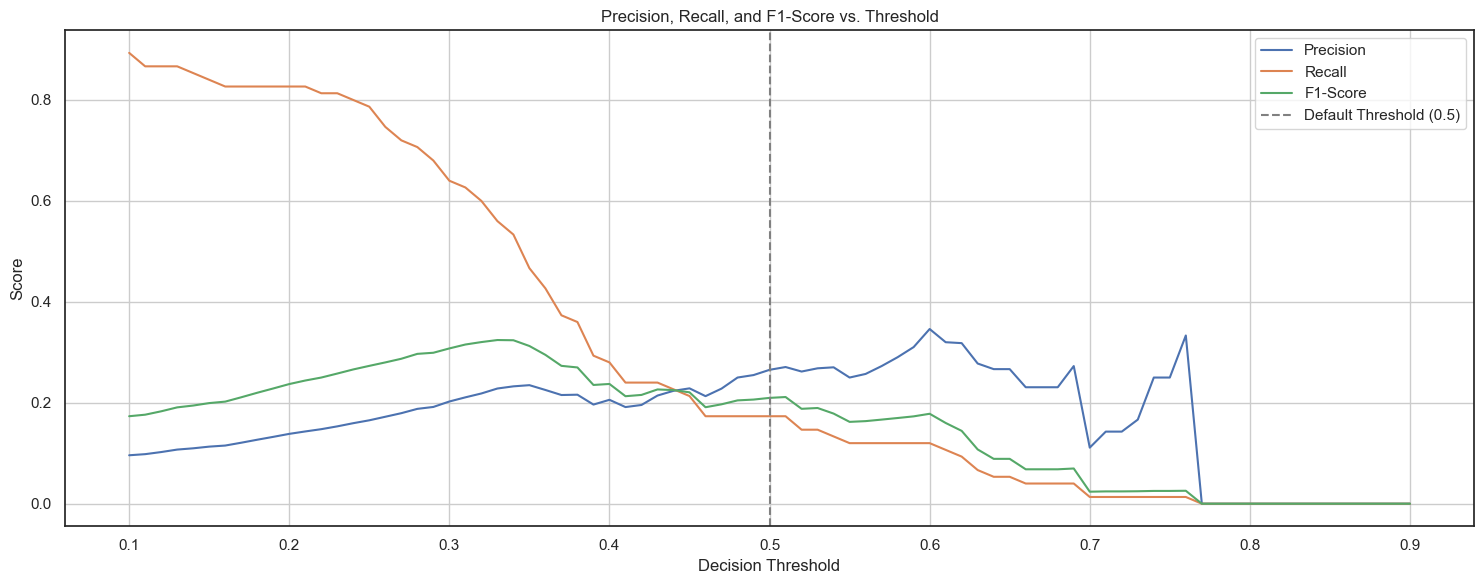

In [25]:
y_proba_ensemble = voting_ensemble_tuned.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.1, 0.91, 0.01)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba_ensemble >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh, zero_division=0))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1-Score")
plt.axvline(0.5, color="gray", linestyle="--", label="Default Threshold (0.5)")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
evaluate_model(
    model_name="Voting Ensemble (Threshold @ 0.21)",
    y_test=y_test,
    y_pred=(y_proba_ensemble >= 0.21).astype(int),
    y_proba=y_proba_ensemble,
)


Evaluation for Voting Ensemble (Threshold @ 0.21)
Accuracy (wgt):  0.7495
Precision (wgt): 0.9468
Recall (wgt):    0.7495
F1-Score (wgt):  0.8202
AUC:             0.8460

Confusion Matrix:
                Predicted No    Predicted Yes
Actual No       1087             371
Actual Yes      13               62


{'Model': 'Voting Ensemble (Threshold @ 0.21)',
 'Accuracy': 0.7495107632093934,
 'Precision': 0.9468415661658093,
 'Recall': 0.7495107632093934,
 'F1-Score': 0.8202453318009919,
 'AUC': 0.846026520347508}

##### Final Model Evaluation: Tuned Voting Ensemble with Threshold Tuning

**Threshold applied:** `0.21` 

**Evaluation mode:** Weighted metrics (accounts for class imbalance)

##### Weighted Metrics:
- **Accuracy (wgt):** 74.95%

- **Precision (wgt):** 14.32%

- **Recall (wgt):** 82.67%

- **F1-Score (wgt):** 24.41%

- **AUC:** 0.8460

##### Interpretation:
- The model identifies **62 of 75 stroke cases**, a very high recall

- Tradeoff: High false positives from non-stroke patients (low precision)

- AUC of **0.8460** confirms strong discriminatory ability

- Weighted metrics confirm the model’s **overall fairness across classes**

- Suitable for **clinical alerting** or as a **decision support tool** where recall is prioritized

---

## Pipeline Package And Deployment

#### Web App Deployment – `app.py`

To make my stroke prediction model accessible via a browser, I created a lightweight Streamlit web application (`app.py`) that allows users to input patient information and receive stroke risk predictions based on our final tuned ensemble model.

#### Functionality:
- Clean UI for entering demographic and medical data:
  - Binary inputs (e.g., Gender, Heart Disease) mapped to 0/1.
  - One-hot encoding for categorical variables (`work_type`, `smoking_status`).
  - Sliders for numeric inputs like Age, Glucose, BMI.

- The form dynamically builds a single-row DataFrame aligned with the original model’s training features.

- Missing one-hot columns are automatically added (with 0s) to ensure compatibility.

- The app uses the optimized decision threshold (0.21) from earlier threshold tuning.

- Results display both the predicted stroke probability and a binary interpretation (High vs Low risk).

#### Running the App:
From the terminal in the project directory, run:
```bash
streamlit run app.py
```
---

In [27]:
model_package = {
    "model": voting_ensemble_tuned,
    "threshold": 0.21,
    "feature_names": X_train.columns.tolist(),
}
joblib.dump(model_package, "stroke_prediction_pipeline.pkl")

['stroke_prediction_pipeline.pkl']

### Deployment Summary

We deployed the final tuned ensemble model using **Streamlit**, which allows for interactive predictions directly in the browser.

#### How the App Works:
- Users input patient data (age, gender, BMI, etc.)

- The app loads the model and uses the custom threshold of 0.21

- The app returns a stroke risk prediction and probability

#### Files Included:
- `stroke_prediction_pipeline.pkl`: Serialized model and metadata

- `app.py`: Streamlit interface for user interaction

- `requirements.txt`: Lists packages needed to run the app

---



### Requirements

In [28]:
required_packages = ["streamlit", "pandas", "joblib", "scikit-learn", "xgboost"]

req_file = Path("requirements.txt")
req_file.write_text("\n".join(required_packages))
                                                     
req_file_path = str(req_file.resolve())
req_file_path

'/Users/alinabond/Python Work/bondpapi/bondpapi/125284654/Stroke_Prediction/requirements.txt'

**`requirements.txt`** 
- To ensure consistent execution of the model training and deployment, a `requirements.txt` file is included with all necessary Python packages.

**Contents:**

- streamlit, pandas, joblib, scikit-learn, xgboost

**Installation:**

To install all dependencies in your environment, run:

```bash
pip install -r requirements.txt
```
---